# Ensemble Cross-validation for Multitask Regression

In [ ]:
import sys
sys.path.append('..')

import os
n_cores = int(8)
os.environ["OMP_NUM_THREADS"] = f"{n_cores}"
os.environ["OPENBLAS_NUM_THREADS"] = f"{n_cores}"
os.environ["MKL_NUM_THREADS"] = f"{n_cores}"
os.environ["VECLIB_MAXIMUM_THREADS"] = f"{n_cores}"
os.environ["NUMEXPR_NUM_THREADS"] = f"{n_cores}"
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'

import numpy as np
from sklearn_ensemble_cv import reset_random_seeds
import matplotlib.pyplot as plt

reset_random_seeds(0)

We make up some fake data for illustration. Below, the response is of dimension 2.

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=300, n_features=200,
                       n_informative=5, n_targets=2,
                       random_state=0, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## The Ensemble class

For users who want to have more control of the ensemble predictor, this section introduces lower-level class and object that we use to implement the cross-validation methods.
For users who just want to use easy interface functions, you can safely skip this section.

We provide `Ensemble` a class for ensemble predictor, whose base class is `sklearn.ensemble.BaggingRegressor`.
This means that the usage of `Ensemble` is basically the same as the latter, except the new class includes several new member functions that we will illustrate below.



### Initialize an object

The initialization of `Ensemble` class is the same as `sklearn.ensemble.BaggingRegressor`, where 

1. The base estimator object, whose hyperparameter `kwargs_regr` is specified when it is initialized. In the following example, we use decision tree as the base estimator. 
2. The hyperparameters for building an ensemble, such as `n_estimators`, `max_samples`, `max_features`, and etc.

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn_ensemble_cv import Ensemble
kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr = Ensemble(estimator=DecisionTreeRegressor(**kwargs_regr), n_estimators=100, **kwargs_ensemble)

The prediction is of the same dimension as the response. 

In [4]:
regr.fit(X_train, y_train)
Y_test_hat = regr.predict(X_test)
Y_test_hat.shape

(150, 2)

We can also get prediction from individual base estimators.

In [5]:
Y_train_hat = regr.predict_individual(X_train)
Y_train_hat.shape

(150, 2, 100)

### Compute ECV estimate of the prediction risk

Below, we use function `compute_ecv_estimate` to estimate the prediction risk for various ensemble size $M=1,\ldots,100$, only using the first $M_0=30$ trees.

In [6]:
# compute the risk estimate of the ensemble
df_est = regr.compute_ecv_estimate(X_train, y_train, M0=30, return_df=True)
# compute the risk of the ensemble on the test set
df_risk = regr.compute_risk(X_test, y_test, return_df=True)

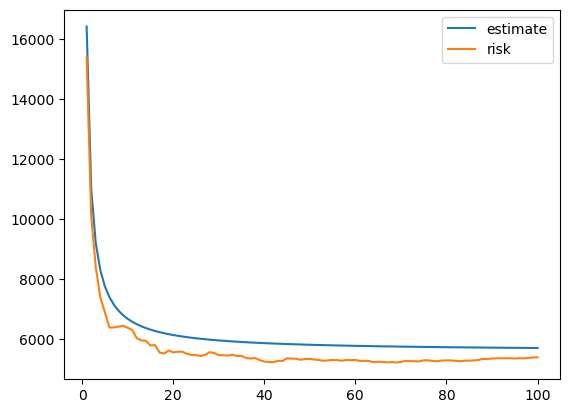

In [7]:
plt.plot(df_est['M'], df_est['estimate'], label='estimate')
plt.plot(df_risk['M'], df_risk['risk'], label='risk')
plt.legend()
plt.show()

## ECV for tuning hyperparameters

For tuning hyperparameters, such as `max_samples` and `max_features` for the ensemble predictors, and `max_depth` and `min_samples_leaf` for all base predictors, we can make two grids of these two types of tuning hyperparameters respectively.

We recommend using `np.array` for each parameter, and make sure to use the correct dtypes that `sklearn` accept.
If one want to set some hyperparameter to a fix value, simply provide it in the grid as either a scalar or a list/array with length one.

In [8]:
from sklearn_ensemble_cv import ECV

# Hyperparameters for the base regressor
grid_regr = {    
    'max_depth':np.array([6,7], dtype=int), 
    }
# Hyperparameters for the ensemble
grid_ensemble = {
    'max_features':np.array([0.9,1.]),
    'max_samples':np.array([0.6,0.7]),
}

res_ecv, info_ecv = ECV(
    X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble,
    X_test=X_test, Y_test=y_test,
    M=50, M0=25, return_df=True
)

In [9]:
info_ecv

{'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'random_state': 0,
  'n_estimators': 50,
  'max_features': 1.0,
  'max_samples': 0.7},
 'best_n_estimators': 50,
 'best_params_index': 3,
 'best_score': 6118.919276518704,
 'delta': 0.0,
 'M_max': inf,
 'best_n_estimators_extrapolate': inf,
 'best_score_extrapolate': 5905.261207161817}

In [10]:
res_ecv.iloc[info_ecv['best_params_index']]

max_depth           6.000000
max_features        1.000000
max_samples         0.700000
risk_val-1      16588.164675
risk_val-2      11246.712941
                    ...     
risk_test-46     5698.734060
risk_test-47     5702.237709
risk_test-48     5709.943647
risk_test-49     5712.515747
risk_test-50     5722.970560
Name: 3, Length: 104, dtype: float64

## SplitCV

In [11]:
from sklearn_ensemble_cv import splitCV
res_splitcv, info_splitcv = splitCV(
        X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble,
        M=50, return_df=True, X_test=X_test, Y_test=y_test,
        random_state=0, test_size=0.25,
        )

In [12]:
info_splitcv

{'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'random_state': 0,
  'n_estimators': 50,
  'max_features': 1.0,
  'max_samples': 0.6},
 'best_n_estimators': 34,
 'best_params_index': 2,
 'best_score': 5240.007705341309,
 'split_params': {'index_train': array([ 61,  92, 112,   2, 141,  43,  10,  60, 116, 144, 119, 108,  69,
         135,  56,  80, 123, 133, 106, 146,  50, 147,  85,  30, 101,  94,
          64,  89,  91, 125,  48,  13, 111,  95,  20,  15,  52,   3, 149,
          98,   6,  68, 109,  96,  12, 102, 120, 104, 128,  46,  11, 110,
         124,  41, 148,   1, 113, 139,  42,   4, 129,  17,  38,   5,  53,
         143, 105,   0,  34,  28,  55,  75,  35,  23,  74,  31, 118,  57,
         131,  65,  32, 138,  14, 122,  19,  29, 130,  49, 136,  99,  82,
          79, 115, 145,  72,  77,  25,  81, 140, 142,  39,  58,  88,  70,
          87,  36,  21,   9, 103,  67, 117,  47]),
  'index_val': array([114,  62,  33, 107,   7, 100,  40,  86,  76,  71, 134,  51,  73,
  

In [13]:
res_splitcv.iloc[info_splitcv['best_params_index']]

max_depth           6.000000
max_features        1.000000
max_samples         0.600000
risk_val-1      19024.169727
risk_val-2      12610.242080
                    ...     
risk_test-46     6833.434198
risk_test-47     6828.288653
risk_test-48     6805.733968
risk_test-49     6763.855064
risk_test-50     6762.709618
Name: 2, Length: 103, dtype: float64

## KFoldCV

In [14]:
from sklearn_ensemble_cv import KFoldCV
res_kfoldcv, info_kfoldcv = KFoldCV(
        X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble,
        M=50, return_df=True, X_test=X_test, Y_test=y_test,
        shuffle=True, random_state=0, n_splits=5,
        )

In [15]:
info_kfoldcv

{'best_params_regr': {'max_depth': 7},
 'best_params_ensemble': {'random_state': 0,
  'n_estimators': 50,
  'max_features': 1.0,
  'max_samples': 0.7},
 'best_n_estimators': 32,
 'best_params_index': 7,
 'best_score': 6961.841676288075,
 'val_score': array([[[23737.87238121, 30132.91179502, 30843.47362515, 28137.92795717,
          33399.49306834],
         [16257.2078051 , 23794.78292394, 23212.03247225, 21195.09262109,
          26952.11363943],
         [15443.15947895, 23989.58436141, 21341.04339101, 18529.64918437,
          22063.59523662],
         ...,
         [ 8022.52682882, 15997.12131698, 16240.36668888, 14929.25864793,
          20074.35581705],
         [ 7945.93509948, 15893.45991707, 16158.51048811, 14794.6479552 ,
          19989.06648138],
         [ 7915.96842979, 15900.1227764 , 16110.65661389, 14796.65783126,
          19946.98247012]],
 
        [[24481.34001435, 29673.33521269, 32222.32927357, 27241.45052042,
          33134.92006409],
         [15711.7815384 , 

In [16]:
res_kfoldcv.iloc[info_kfoldcv['best_params_index']]

max_depth           7.000000
max_features        1.000000
max_samples         0.700000
risk_val-1      18036.725421
risk_val-2      12449.665457
                    ...     
risk_test-46     6818.256763
risk_test-47     6822.130614
risk_test-48     6831.305227
risk_test-49     6844.258926
risk_test-50     6849.421744
Name: 7, Length: 103, dtype: float64

Based on the test set, ECV gives the lowest mean square error of the cross-validated parameters (`risk_test-50`).